# Dirichlet VAE
Training and evaluation of the DVAE approach for Anomaly Detection proposed by Dillon et al. in "Better latent spaces for better auto-encoders".
* https://github.com/bmdillon/jet-mixture-vae

In [1]:
import os
import numpy as np
import tensorflow as tf

from tensorflow_addons.optimizers import AdamW

os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
import ad

from ad import utils
from ad.models.others import DirichletVAE

utils.set_random_seed(42)
ad.plot.set_style()

Random seed 42 set.


In [2]:
tf.keras.backend.set_floatx('float64')

In [3]:
%load_ext autoreload
%autoreload 2

Training set:

In [4]:
qcd = utils.read_npz(folder=os.path.join('data/n_tracks', 'train'),
                     dtype=np.float32, keep='qcd',
                     verbose=False, keys=['images', 'labels', 'masses'])

suep = utils.read_npz(folder=os.path.join('data/n_tracks', 'test'),
                      dtype=np.float32, keep='suep',
                      verbose=False, keys=['images', 'labels', 'masses'])

svj = utils.read_npz(folder=os.path.join('data/n_tracks', 'test'),
                     dtype=np.float32, keep='svj',
                     verbose=False, keys=['images', 'labels', 'masses'])

In [6]:
# compute fraction of signal samples to use in training
num = int(0.01 * len(qcd['images']))
num

2547

In [8]:
def to_mask_image(x: np.ndarray):
    return (x > 0.0).astype(np.float64)[..., 0, np.newaxis]

In [9]:
suep_idx = np.random.choice(len(suep['images']), size=num, replace=False)
svj_idx = np.random.choice(len(svj['images']), size=num, replace=False)

# concat mask images
x_train = np.concatenate([to_mask_image(qcd['images']),
                          to_mask_image(suep['images'][suep_idx]),
                          to_mask_image(svj['images'][svj_idx])])

x_train = x_train.reshape((x_train.shape[0], -1))

# concat labels
y_train = np.concatenate([qcd['labels'], suep['labels'][suep_idx], svj['labels'][svj_idx]])
m_train = np.concatenate([qcd['masses'], suep['masses'][suep_idx], svj['masses'][svj_idx]])

In [10]:
del qcd, suep, svj
utils.free_mem()

1146

In [11]:
vae = DirichletVAE(input_shape=(72, 58, 1), concentration=(1.0, 0.25, 0.1))

vae.compile(optimizer=AdamW(learning_rate=0.001, beta_1=0.9, beta_2=0.99,
                            epsilon=1e-8, weight_decay=1e-4, clipnorm=1.0))

early_stop = tf.keras.callbacks.EarlyStopping(patience=50,
                                              restore_best_weights=True,
                                              verbose=1)

prior mean: [[ 1.2296265  -0.15666783 -1.0729586 ]]
prior variance: [[2. 3. 5.]]


In [12]:
h = vae.fit(x=x_train, y=y_train, validation_split=0.2,
            epochs=200, verbose=1, callbacks=[early_stop], batch_size=256)

Epoch 1/200
813/813 [==============================] - 32s 34ms/step - kl_loss: 674.9896 - latent_loss: 347229245.4835 - loss: 114704588.8549 - auc_z: 0.0000e+00 - bkg_w: 0.3378 - sig_w: 0.0000e+00 - grads_norm: 8084868998.0517 - weights_norm: 46.2061 - val_kl_loss: 765.4824 - val_latent_loss: 7.9108 - val_loss: 766.2735 - val_auc_z: 0.4551 - val_bkg_w: 0.3468 - val_sig_w: 0.3363
Epoch 2/200
813/813 [==============================] - 26s 32ms/step - kl_loss: 670.1618 - latent_loss: 4.0239 - loss: 670.5597 - auc_z: 0.0000e+00 - bkg_w: 0.3473 - sig_w: 0.0000e+00 - grads_norm: 1.0688 - weights_norm: 65.3581 - val_kl_loss: 762.8787 - val_latent_loss: 16.2630 - val_loss: 764.5050 - val_auc_z: 0.4749 - val_bkg_w: 0.3538 - val_sig_w: 0.3634
Epoch 3/200
813/813 [==============================] - 26s 32ms/step - kl_loss: 668.5326 - latent_loss: 4.3318 - loss: 668.9579 - auc_z: 0.0000e+00 - bkg_w: 0.3544 - sig_w: 0.0000e+00 - grads_norm: 1.3848 - weights_norm: 80.9953 - val_kl_loss: 761.6981 - v

In [13]:
vae.save_weights('weights/dirichlet_vae/weights')

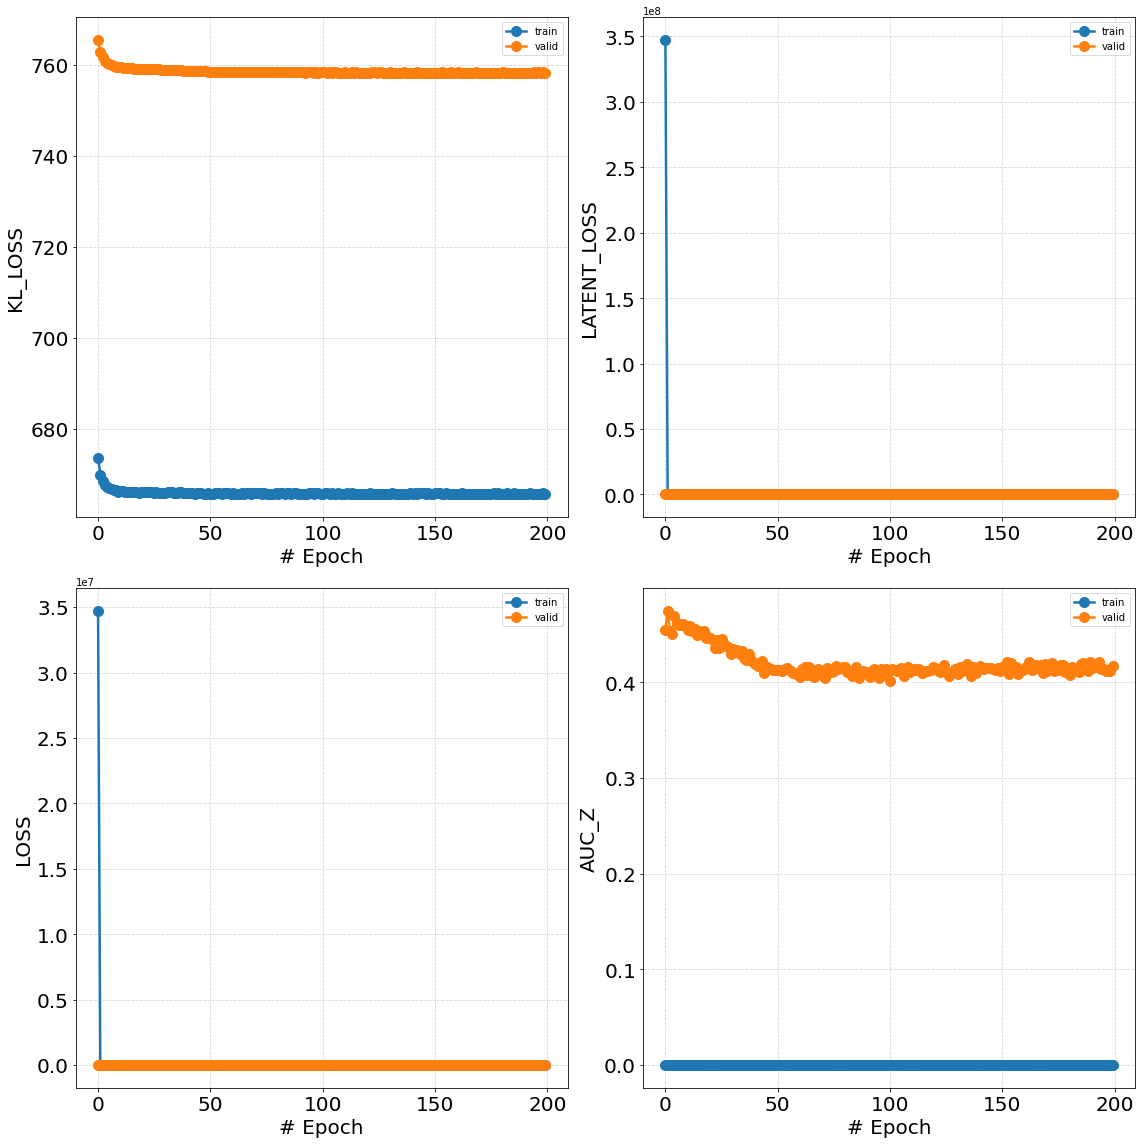

In [14]:
ad.plot.history(h, keys=['kl_loss', 'latent_loss', 'loss', 'auc_z'])

Evaluation

In [12]:
vae.load_weights('weights/dirichlet_vae/weights')

In [13]:
test = utils.read_npz(folder=os.path.join('data/n_tracks', 'test'),
                      dtype=np.float32,
                      verbose=False, keys=['images', 'labels', 'masses'])

In [14]:
utils.free_mem()
x_mask = to_mask_image(test['images'])
y_test = test['labels']
m_test = test['masses']

del test
utils.free_mem()

0

In [11]:
with tf.device('cpu'):
    z_mu, _, _ = vae.predict(x_mask.reshape((x_mask.shape[0], -1)),
                             batch_size=256, verbose=1)

1343/1343 [==============================] - 39s 29ms/step


In [15]:
with tf.device('cpu'):
    z_softmax = tf.nn.softmax(z_mu)

latents = {'Z': z_mu, 'Z (softmax)': z_softmax.numpy()}

scores = ad.eval2.latents_as_scores(latents, y=y_test, masses=m_test)

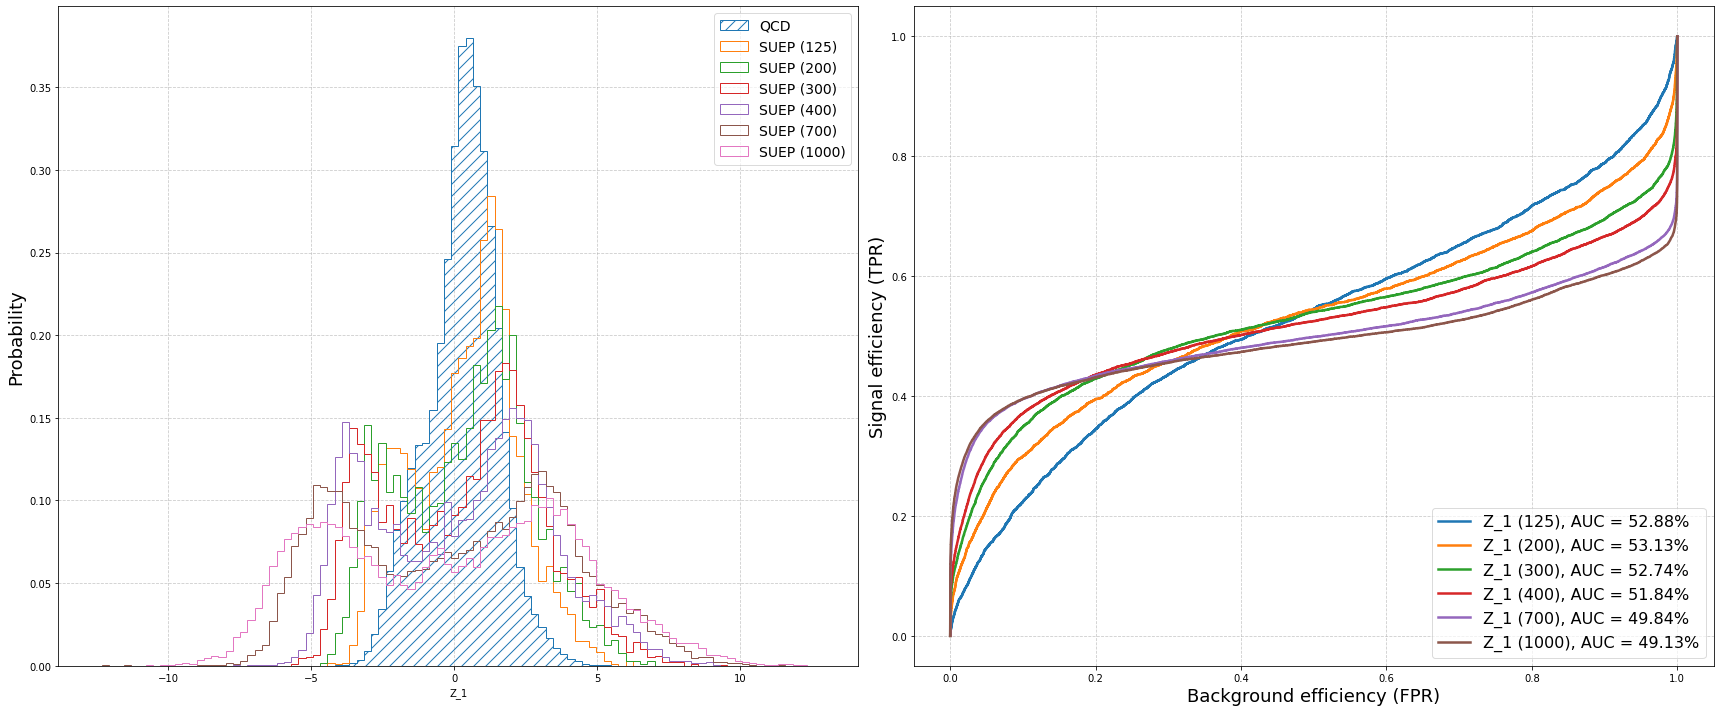

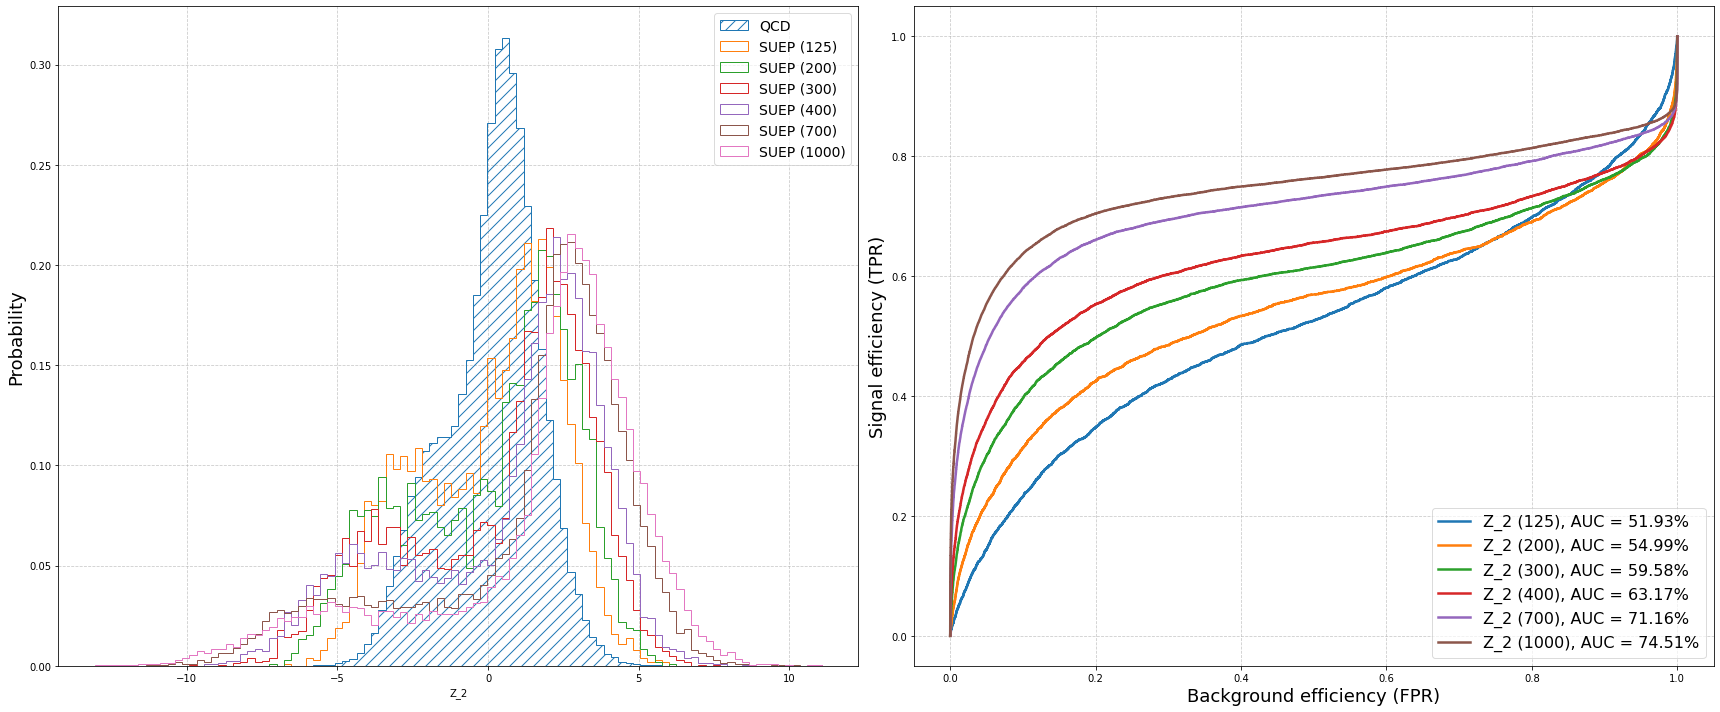

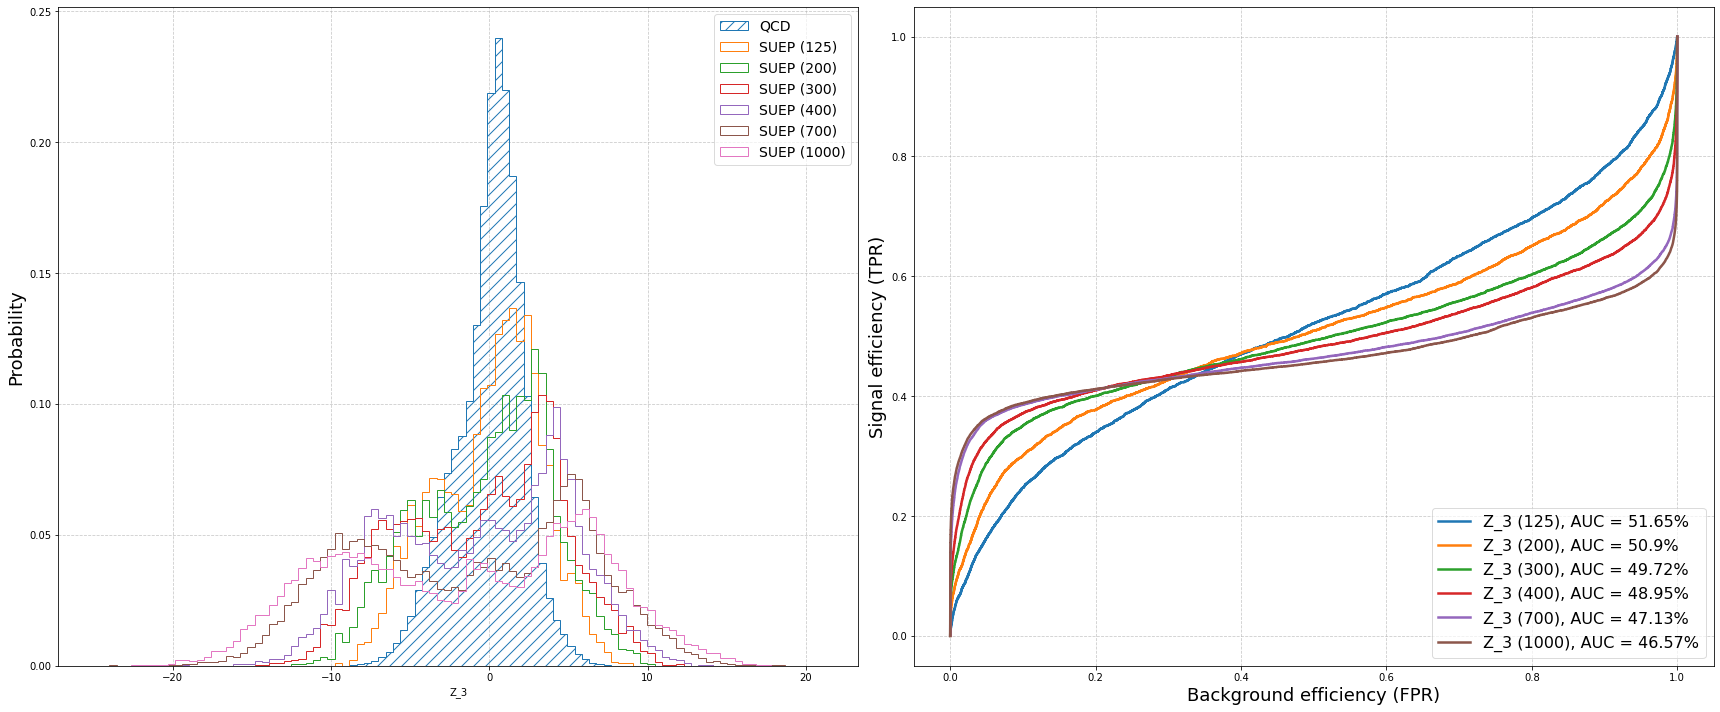

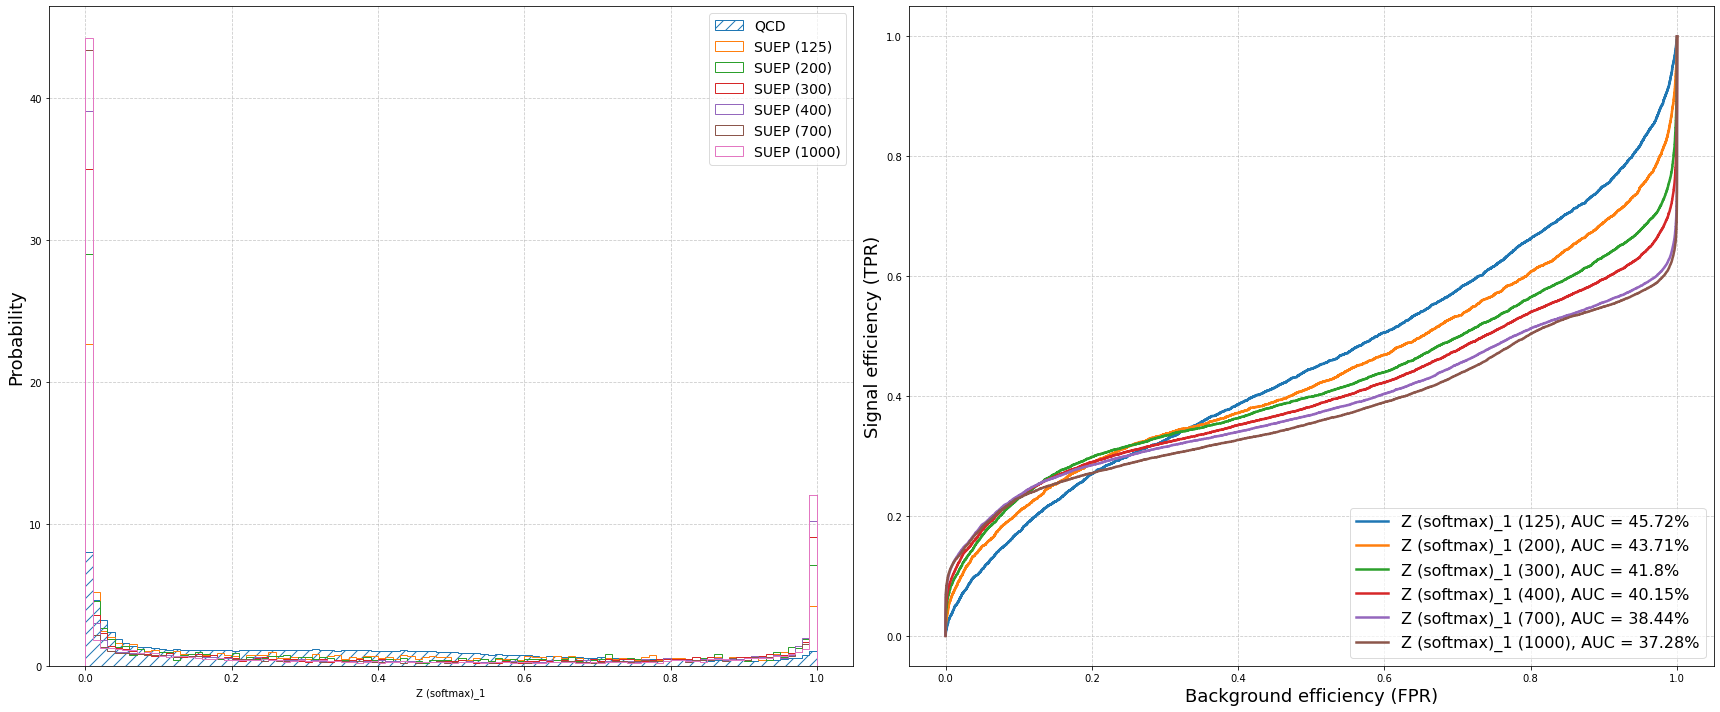

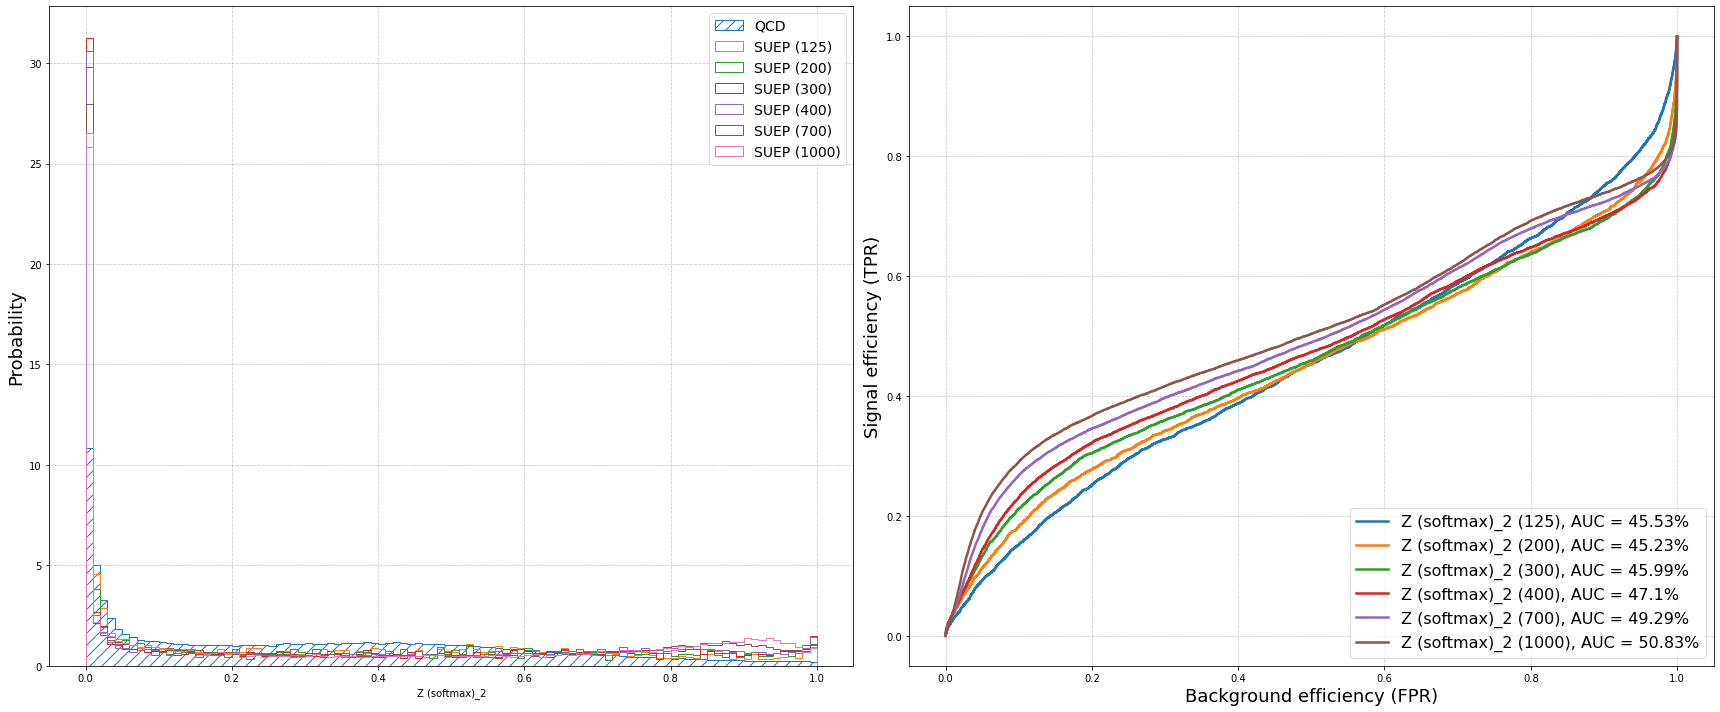

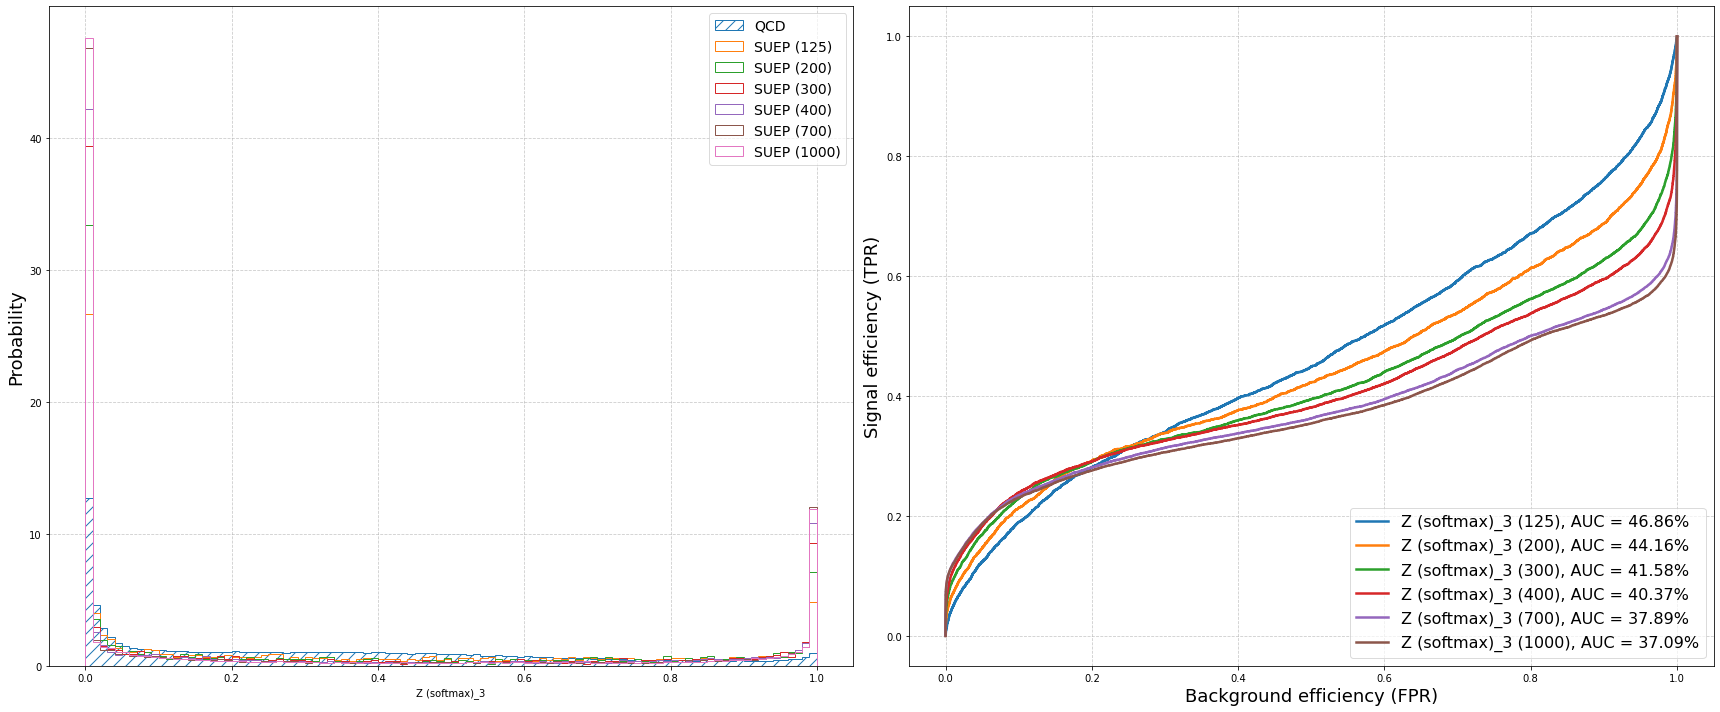

[Z_2]           Avg: 62.55%, AUC: [51.93 54.99 59.58 63.17 71.16 74.51]
[Z_1]           Avg: 51.59%, AUC: [52.88 53.13 52.74 51.84 49.84 49.13]
[Z_3]           Avg: 49.15%, AUC: [51.65 50.9  49.72 48.95 47.13 46.57]
[Z (softmax)_2] Avg: 47.33%, AUC: [45.53 45.23 45.99 47.1  49.29 50.83]
[Z (softmax)_3] Avg: 41.32%, AUC: [46.86 44.16 41.58 40.37 37.89 37.09]
[Z (softmax)_1] Avg: 41.18%, AUC: [45.72 43.71 41.8  40.15 38.44 37.28]
[Z_2]           Avg: 10.71%, FPR@40: [26.0655, 17.385, 10.1486, 6.6558, 2.5724, 1.4205]
[Z_1]           Avg: 16.31%, FPR@40: [25.4884, 21.0271, 15.294, 13.7242, 11.1976, 11.1159]
[Z_3]           Avg: 19.78%, FPR@40: [28.3088, 24.2277, 19.9128, 17.117, 14.8738, 14.2302]
[Z (softmax)_2] Avg: 35.47%, FPR@40: [42.0242, 40.4503, 38.331, 34.9158, 30.6015, 26.4681]
[Z (softmax)_1] Avg: 52.73%, FPR@40: [42.3163, 47.1073, 50.4684, 54.5571, 59.0866, 62.8532]
[Z (softmax)_3] Avg: 52.93%, FPR@40: [40.76, 45.3071, 51.5157, 55.1254, 61.1371, 63.7195]


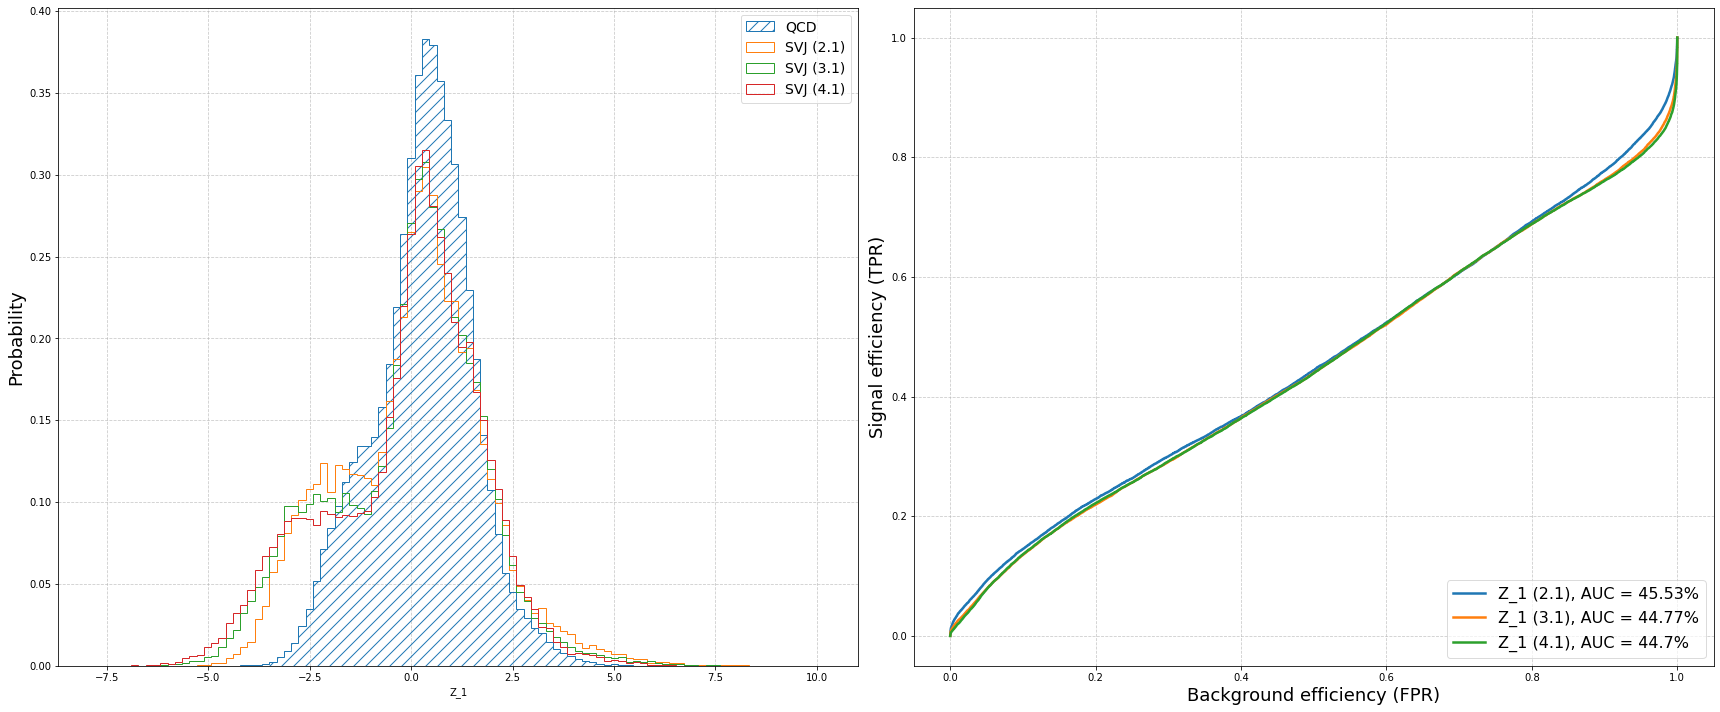

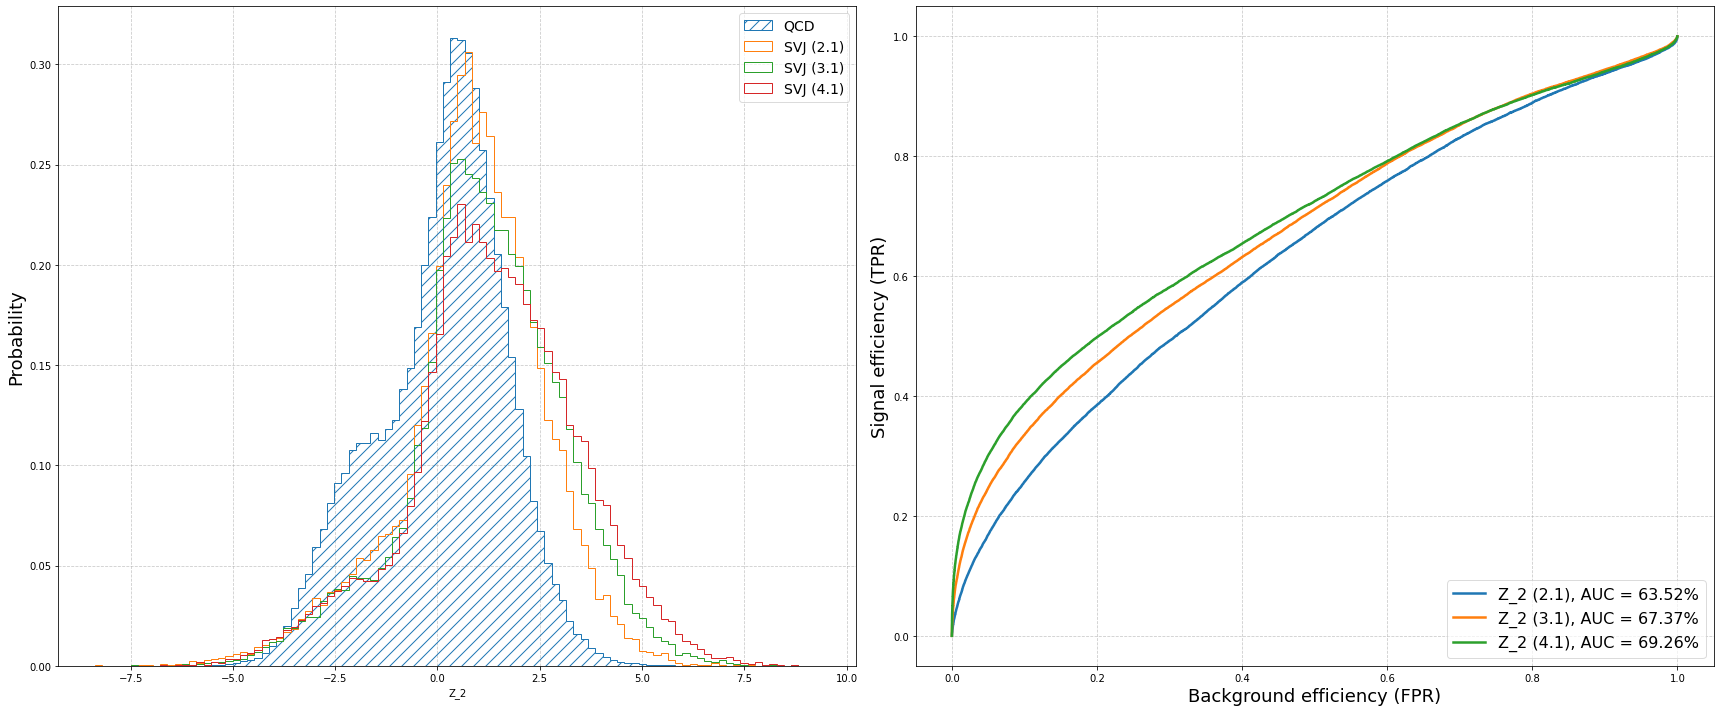

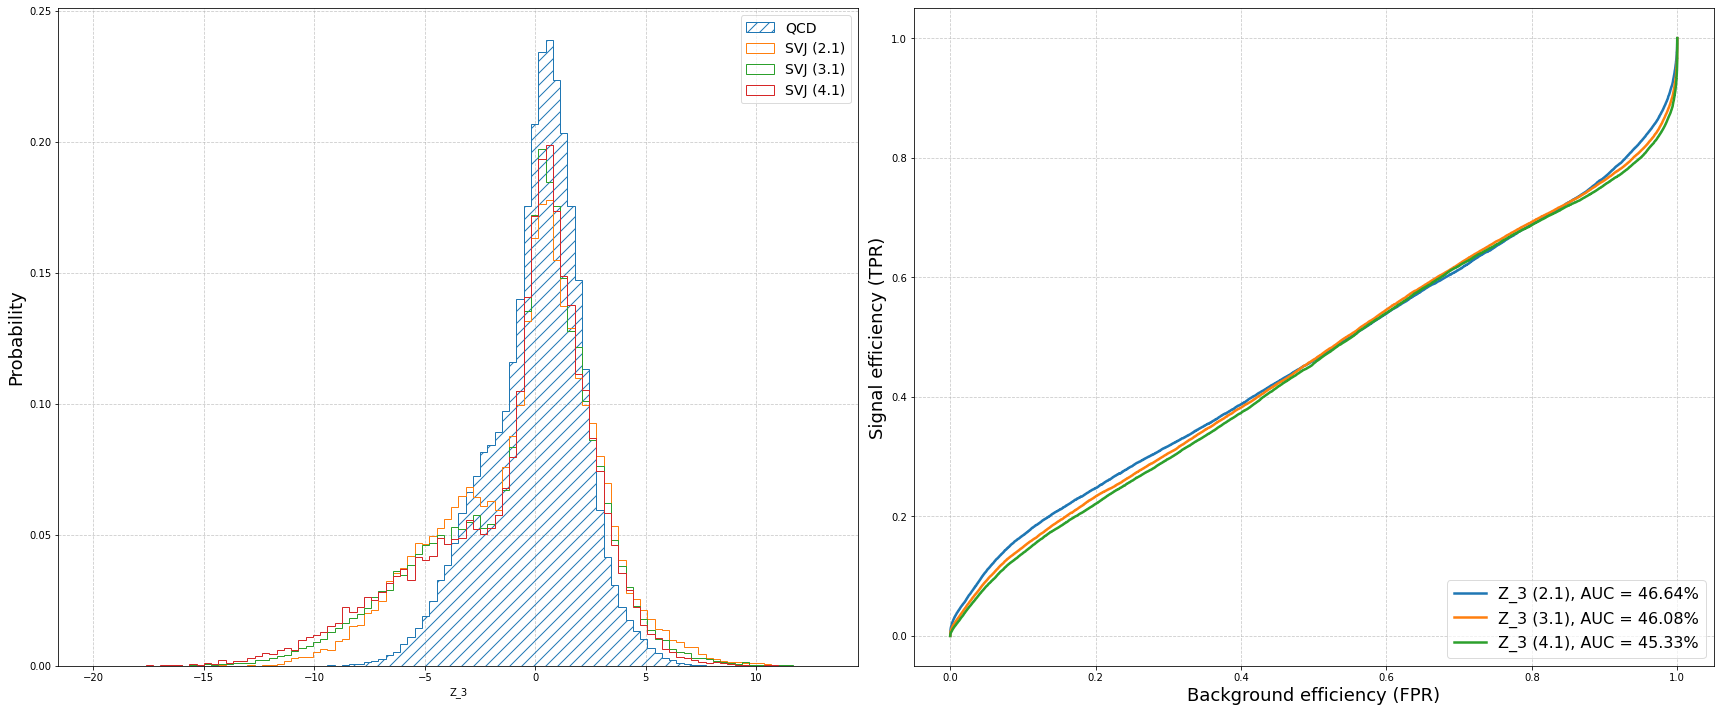

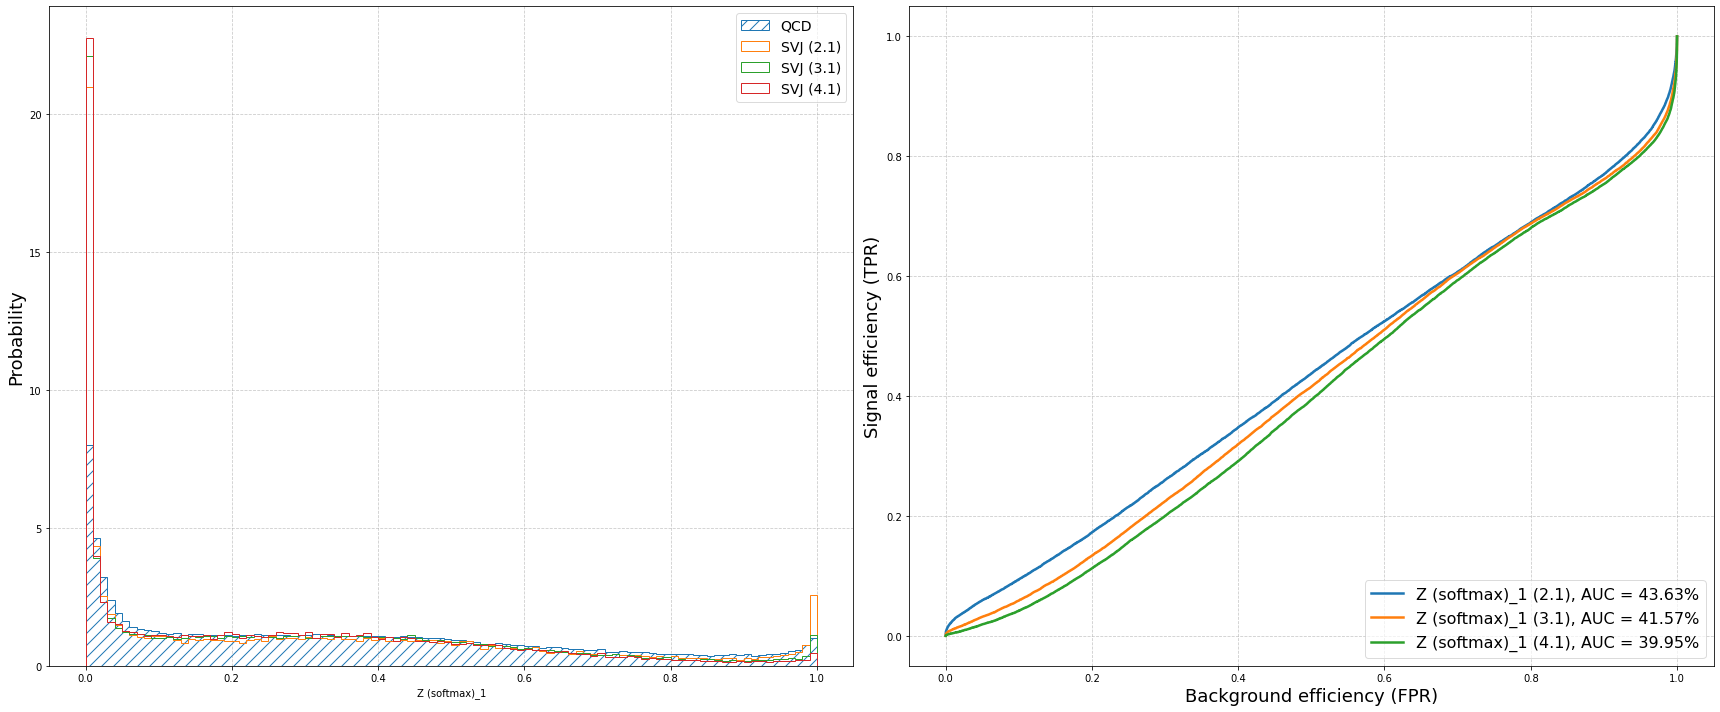

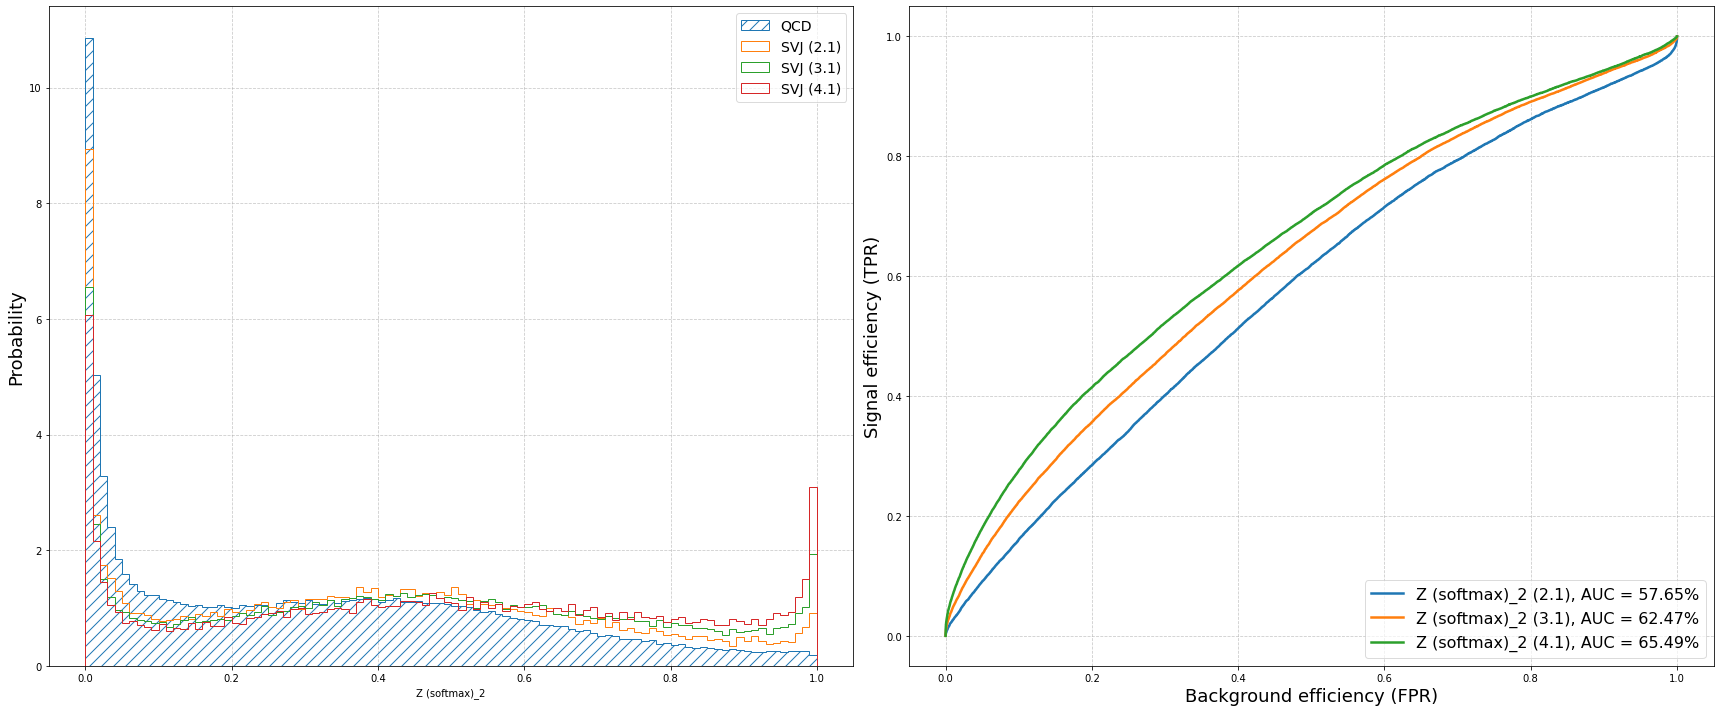

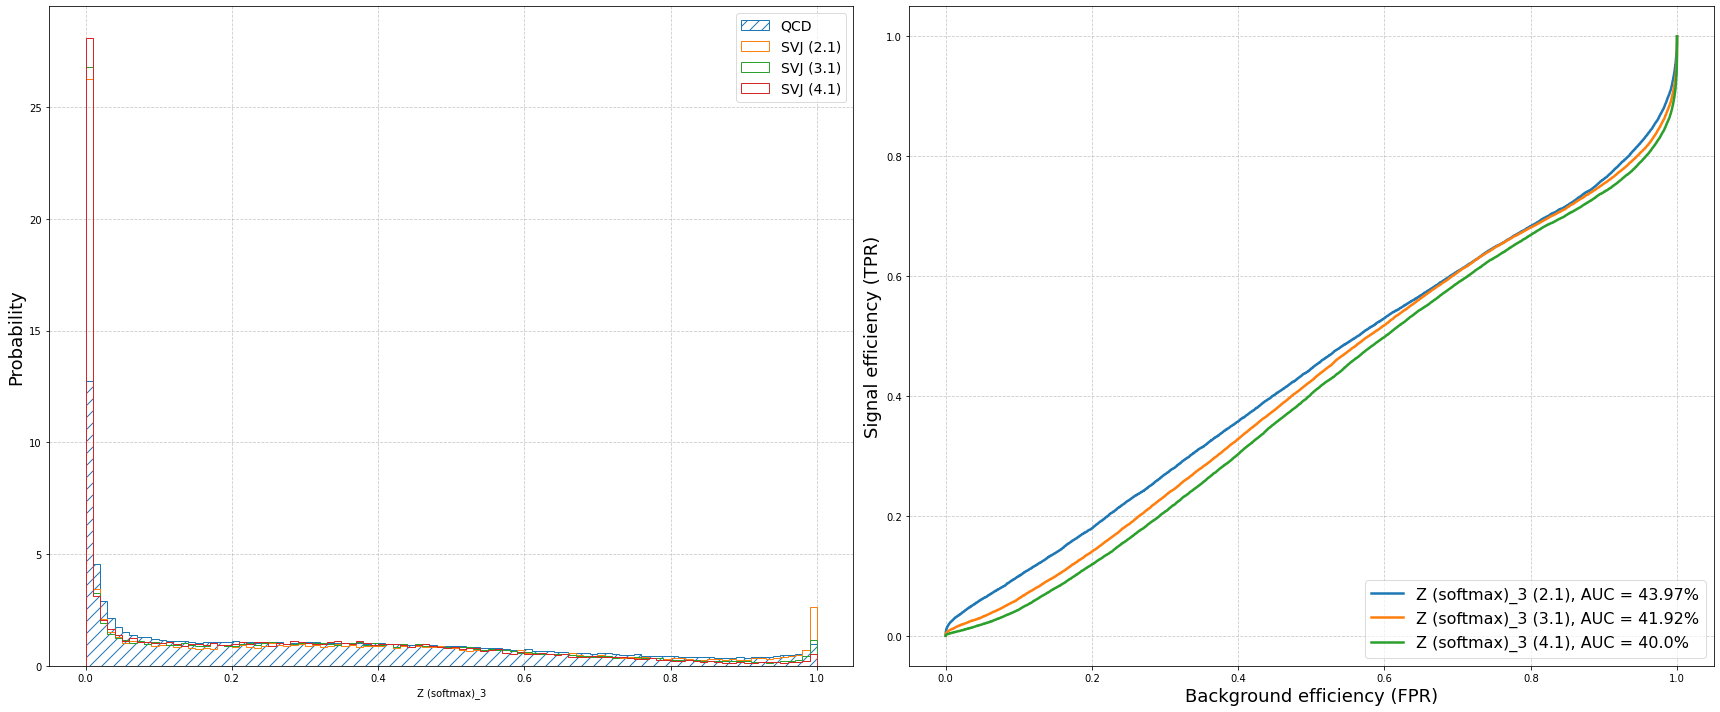

[Z_2]           Avg: 66.72%, AUC: [63.52 67.37 69.26]
[Z (softmax)_2] Avg: 61.87%, AUC: [57.65 62.47 65.49]
[Z_3]           Avg: 46.02%, AUC: [46.64 46.08 45.33]
[Z_1]           Avg: 45.0%, AUC: [45.53 44.77 44.7 ]
[Z (softmax)_3] Avg: 41.96%, AUC: [43.97 41.92 40.  ]
[Z (softmax)_1] Avg: 41.72%, AUC: [43.63 41.57 39.95]
[Z_2]           Avg: 15.74%, FPR@40: [21.4203, 14.8926, 10.9202]
[Z (softmax)_2] Avg: 24.11%, FPR@40: [29.8751, 23.8052, 18.6633]
[Z_3]           Avg: 42.34%, FPR@40: [41.5993, 42.2963, 43.1156]
[Z_1]           Avg: 44.67%, FPR@40: [44.3921, 44.7247, 44.8999]
[Z (softmax)_3] Avg: 47.23%, FPR@40: [44.6665, 47.2989, 49.715]
[Z (softmax)_1] Avg: 48.21%, FPR@40: [45.8478, 48.1822, 50.5954]


In [16]:
roc = ad.plot.roc_per_mass(bkg_scores=scores['qcd'], signal_scores=scores['suep'])
ad.eval2.print_by_auc(roc)
ad.eval2.print_fpr_at_n_tpr(roc)

roc = ad.plot.roc_per_mass(bkg_scores=scores['qcd'], signal_scores=scores['svj'])
ad.eval2.print_by_auc(roc)
ad.eval2.print_fpr_at_n_tpr(roc)